In [60]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage
import os

from skimage import io
from skimage.io import imread, imshow, imsave
from skimage.color import rgb2gray, rgb2hsv
from skimage.measure import label, regionprops, regionprops_table
from skimage.filters import threshold_otsu
from scipy.ndimage import median_filter
from matplotlib.patches import Rectangle


1
10
100
101
102
103
104
105
106
107
108
(305, 237, 4)


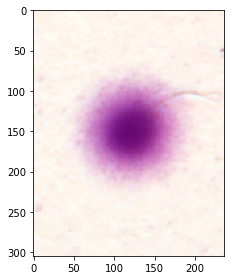

In [61]:
data_root = '../jzsb/1'
save_root = '../jzsb/cropped/1'
img_path = sorted([os.path.join(data_root, name) for name in os.listdir(data_root) if name.endswith('.png')])
for i in range(len(img_path)):
    img_name = os.path.split(img_path[i])[-1]
    img_name = img_name.split(')')[0]
    img_name = img_name.split('(')[1]
    print(img_name)
    img = io.imread(img_path[i])
    if i ==10:
        imshow(img)
        print(img.shape)#注意输入格式
        break

注意此时输入的图片为RGBA格式，使用PIL或者cv2读取时会丢失A分量（透明度分量），在应用skimage.io读取时则会将四个分量全部读取，但在处理时应记得抛弃A分量，才能进行由rgb到gray或者hsv的转变。

先看一下颜色域上该图片情况

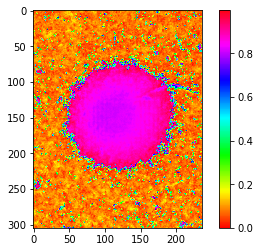

In [62]:
img_hsv = rgb2hsv(img[:,:,:-1])
plt.imshow(img_hsv[:,:,0],cmap = 'hsv')
plt.colorbar()

再看一下亮度域上该图片情况，事实上亮度域上图像精子有些过于小了，不适合作为分离精子和环境的评判标准。

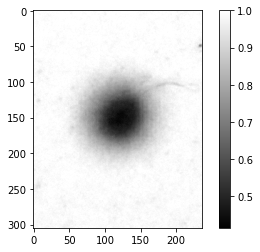

In [63]:
img_hsv = rgb2hsv(img[:,:,:-1])
plt.imshow(img_hsv[:,:,2],cmap = 'gray')
plt.colorbar()

也看一下灰度图，灰度图效果也还不错，一会儿看看换成其它组精子的情况

(305, 237)


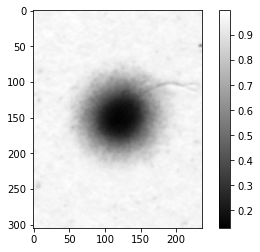

In [64]:
img_gray = rgb2gray(img[:,:,:-1])
print(img_gray.shape)
plt.imshow(img_gray,cmap = 'gray')
plt.colorbar()

In [65]:
img_gray = (img_gray-img_gray.mean())/img_gray.std()
img_gray = (img_gray-img_gray.min())/(img_gray.max()-img_gray.min())
mask_gray = img_gray < 0.4
mask_gray = median_filter(mask_gray,25)

看一下根据hsv的分类

Text(0.5, 1.0, 'gray')

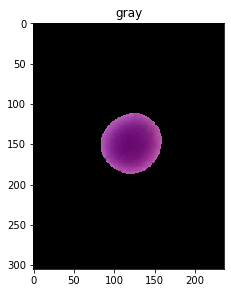

In [66]:
red_gray = img[:,:,0]*mask_gray
green_gray = img[:,:,1]*mask_gray
blue_gray = img[:,:,2]*mask_gray
img_mask_gray = np.dstack((red_gray,green_gray,blue_gray))
plt.plot()
imshow(img_mask_gray)
plt.title("gray")

In [67]:
sperm_blobs = label(mask_gray>0)
properties = ['bbox','convex_area']
df = pd.DataFrame(regionprops_table(sperm_blobs ,properties=properties))
df

,bbox-0,bbox-1,bbox-2,bbox-3,convex_area
0,111,84,187,160,4474


(1, 5)


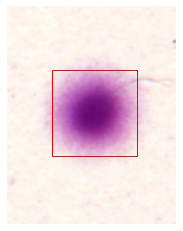

In [68]:
blob_coordinates = [(row['bbox-0'],row['bbox-1'],
                     row['bbox-2'],row['bbox-3'] ,row['convex_area'])for 
                    index, row in df.iterrows()]
blob_coordinates = np.array(blob_coordinates)
fig, ax = plt.subplots(1,1)
print(blob_coordinates.shape)
blob_id = np.argmax(blob_coordinates[:,4]) #选取最大面积连通图
blob = blob_coordinates[blob_id,:]
width = blob[3] - blob[1]
height = blob[2] - blob[0]

delta = min(int(0.3*max(width,height)),blob[1],blob[0],np.size(img,0)-1-blob[2],np.size(img,1)-1-blob[3])
side = max(width,height)+2*delta
patch = Rectangle((blob[1]-delta,blob[0]-delta),
                  side,side,edgecolor = 'r',facecolor='none')
ax.add_patch(patch)
ax.imshow(img)
ax.set_axis_off()

In [69]:
filename = '0 -(1).txt'
# if filename.exist():

# else:
a = 1
b = 1/6.0
c = 2/3.0
d = 2/5.0

f = open(filename,'w')
f.write('{} {:.6f} {:.6f} {:.6f}'.format(a,b,c,d))
f.close()

(120, 120, 4)
108.png


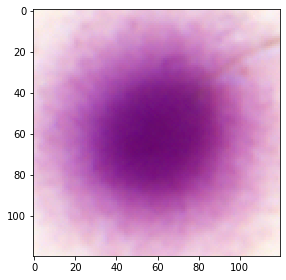

In [70]:
img_final = img[blob[0]-delta:blob[2]+delta,blob[1]-delta:blob[3]+delta,:]
imshow(img_final)
print(img_final.shape)
if '.png' not in img_name:
    img_name+='.png'
print(img_name)
# imsave(os.path.join(save_root,img_name),img_final)